In [5]:
import os
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lsst.daf.persistence import Butler
import fakeInjectionPipeline as fip
import data_process_utils as dpu

from scipy.stats import norm
import scipy.stats as stats

from astropy.table import Table
import astropy.units as u


from scipy.stats import median_abs_deviation
# ignore warnings
# import warnings
# warnings.filterwarnings('ignore')

In [6]:
def get_host_s2n(host_mag_range_list):
    
    conn = sqlite3.connect('../data/table/gal_4639/injection_coord.sqlite')
    host_s2n_dict = {}

    
    for host_mag in host_mag_range_list:
        min_mag = host_mag[0]
        max_mag = host_mag[1]
        
        query = (
                f'SELECT host_s2n FROM injection_coord '
                f"WHERE min_host_mag = {min_mag} AND max_host_mag = {max_mag}"
        )

        host_s2n = pd.read_sql_query(query, conn).to_numpy()
        host_s2n_dict[f'{int(min_mag)}_{int(max_mag)}'] = host_s2n
    return host_s2n_dict

Text(0.5, 0.98, 'host s/n distribution')

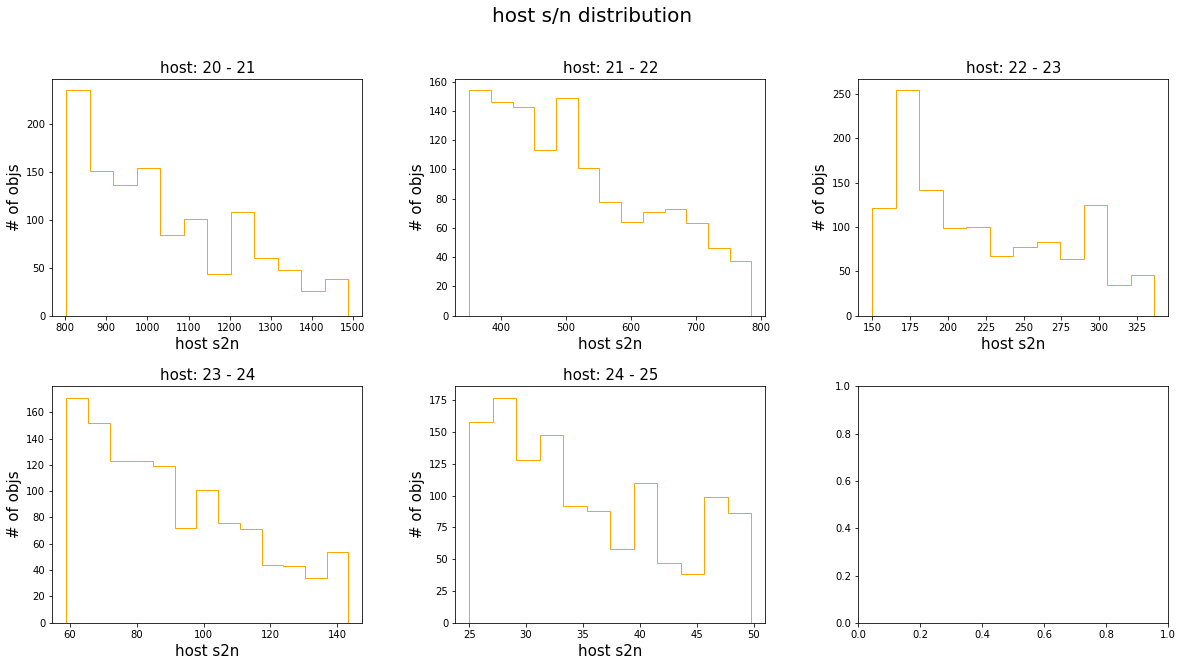

In [66]:
host_mag_range_list = [(20, 21), (21, 22), (22,23), (23, 24), (24, 25)]
host_s2n_dict = get_host_s2n(host_mag_range_list)



fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = [i for i in ax.flat]
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for host_idx, host_mag_range in enumerate(host_mag_range_list):
    min_mag, max_mag = host_mag_range[0], host_mag_range[1]

    s2n = host_s2n_dict[f'{min_mag}_{max_mag}']

    ax[host_idx].hist(s2n ,density=False, bins='auto',
                                color='orange', histtype='step')
    # ax[host_id].set_xlim(-max_x-0.2*max_x, max_x+0.2*max_x)
    ax[host_idx].set_title(f'host: {min_mag} - {max_mag}', size=15)
    ax[host_idx].set_xlabel('host s2n', size=15)
    ax[host_idx].set_ylabel('# of objs', size=15)

plt.suptitle("host s/n distribution", fontsize=20)

In [67]:
class fakeAnalysisFramework():
    def __init__(self, host_mag_list, fake_mag_list, color_list):
        self.host_mag_list = host_mag_list
        self.fake_mag_list = fake_mag_list
        self.color_list = color_list
        self.threshold = 5
        
    @staticmethod
    def cal_eff(fake_src, threshold):
        detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
        detected_fake = detected_fake.loc[
            np.abs(detected_fake.base_PsfFlux_instFlux / detected_fake.base_PsfFlux_instFluxErr) > threshold
        ].copy().reset_index(drop=True)
        eff = len(detected_fake) / len(fake_src)
        err = np.sqrt(eff / len(fake_src))
        n_of_fake = len(detected_fake)
        return eff, err, n_of_fake        
        
    def get_efficiency(self, fake_src_df, host_mag_list=None, fake_mag_list=None):
        if not host_mag_list:
            host_mag_list = self.host_mag_list
        if not fake_mag_list:
            fake_mag_list = self.fake_mag_list
            
        eff_dict, err_dict, n_of_fake_dict = {}, {}, {}
        for host_mag in host_mag_list:
            efficiency_list = []
            err_list = []
            n_of_fake_list = []
            for fake_mag in fake_mag_list:
                fake_mag_str = str(fake_mag).replace('.', '')
                fake_num, detected_fake = 0, 0
                fake_src = fake_src_df.loc[
                    np.logical_and(
                        fake_src_df.host_mag == host_mag, fake_src_df.fake_mag == fake_mag_str
                )].copy().reset_index(drop=True)
                eff, err, n_of_fake = fakeAnalysisFramework.cal_eff(fake_src, self.threshold)
                efficiency_list.append(eff)
                err_list.append(err)
                n_of_fake_list.append(n_of_fake)
            eff_dict[host_mag] = efficiency_list
            err_dict[host_mag] = err_list
            n_of_fake_dict[host_mag] = n_of_fake_list
        return eff_dict, err_dict, n_of_fake_dict
    
    @staticmethod
    def cal_df(fake_src, threshold):
        detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
        detected_fake = detected_fake.loc[
            np.abs(detected_fake.base_PsfFlux_instFlux / detected_fake.base_PsfFlux_instFluxErr) > threshold
        ].copy().reset_index(drop=True)
        df = (detected_fake.base_PsfFlux_instFlux - detected_fake.injected_instFlux) / detected_fake.base_PsfFlux_instFluxErr
        clipped, _, _ = stats.sigmaclip(df)
        return clipped

    def get_df(self, fake_src_df, host_mag, fake_mag):
        fake_mag_str = str(fake_mag).replace('.', '')
        fake_src = fake_src_df.loc[
            np.logical_and(
                fake_src_df.host_mag == host_mag, fake_src_df.fake_mag == fake_mag_str
        )].copy().reset_index(drop=True)
        clipped_df = fakeAnalysisFramework.cal_df(fake_src, self.threshold)
        return clipped_df
        
    def get_median_mad(self, fake_src_df):
        median_dict = {}
        mad_dict = {}
        for host_idx, host_mag in enumerate(self.host_mag_list):
            median_list = []
            mad_list = []
            for fake_mag in self.fake_mag_list:
                clipped = self.get_df(fake_src_df, host_mag, fake_mag)
                median = np.nanmedian(clipped)
                mad = median_abs_deviation(clipped, scale='normal', nan_policy='omit')
                median_list.append(median)
                mad_list.append(mad)
            median_dict[host_mag] = median_list
            mad_dict[host_mag] = mad_list
        return median_dict, mad_dict
    
    def get_s2n(self, fake_src_df, host_mag, fake_mag):
        fake_mag_str = str(fake_mag).replace('.', '')
        fake_src = fake_src_df.loc[
            np.logical_and(
                fake_src_df.host_mag == host_mag, fake_src_df.fake_mag == fake_mag_str
        )].copy().reset_index(drop=True)
        detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
        detected_fake = detected_fake.loc[
            np.abs(detected_fake.base_PsfFlux_instFlux / detected_fake.base_PsfFlux_instFluxErr) > self.threshold
        ].copy().reset_index(drop=True)
        
        s2n = detected_fake.base_PsfFlux_instFlux / detected_fake.base_PsfFlux_instFluxErr
        s2n = s2n.loc[~np.isnan(s2n)].reset_index(drop=True)
        return s2n
    
    @staticmethod
    def get_residual(forced_df, host_mag, fake_mag):
        res_dict = {}
        fake_mag_str = str(fake_mag).replace('.', '')
        forced_table = forced_df.loc[
            np.logical_and(
                forced_df.host_mag == host_mag, forced_df.fake_mag == fake_mag_str
        )].copy().reset_index(drop=True)
        src_f = forced_table['base_PsfFlux_instFlux_diaSrc']
        forced_f = forced_table['base_PsfFlux_instFlux_forced']
        injected_f = forced_table['injected_instFlux']
        src_inj = (src_f - injected_f) / injected_f
        forced_inj = (forced_f - injected_f) / injected_f
        forced_src = (forced_f - src_f) / src_f
        return src_inj, forced_inj, forced_src
    
    def plot_detection(self, ax, eff_dict, err_dict, title):

        for host_idx, host_mag in enumerate(self.host_mag_list):
            color = self.color_list[host_idx]
            ax.errorbar(self.fake_mag_list, eff_dict[host_mag], yerr=err_dict[host_mag],
                        marker='o', ls='--', color=color, label=host_mag + " mag/\'\'2")
        ax.set_xticks(self.fake_mag_list)
        ax.set_xticklabels(self.fake_mag_list)
        ax.set_ylim((-0.1, 1.1))
        ax.set_xlabel('fake mag', size=15)
        ax.set_ylabel('efficiency', size=15)
        ax.set_title(title, size=15)
        ax.legend()
        
    def plot_median(self, ax, median_dict, title):
        for host_idx, host_mag in enumerate(self.host_mag_list):
            color = self.color_list[host_idx]
            median = median_dict[host_mag]
            ax.plot(self.fake_mag_list, median, 'o--', color=color, label=host_mag + "/ \'\'2")
        ax.axhline(y=0, color='gray', label='y = 0')
        ax.set_title(title, size=15)
        ax.set_xlabel('fake mag', size=15)
        ax.set_ylabel(r'median of $\Delta F/\sigma$', size=15)
        ax.legend()
            
    def plot_mad(self, ax, mad_dict, title):
        for host_idx, host_mag in enumerate(self.host_mag_list):
            color = self.color_list[host_idx]
            mad = mad_dict[host_mag]
            ax.plot(self.fake_mag_list, mad, 'o--', color=color, label=host_mag + "/ \'\'2")
        ax.axhline(y=1, color='gray', label='y = 1')
        ax.set_title(title, size=15)
        ax.set_xlabel('fake mag', size=15)
        ax.set_ylabel(r'mad of $\Delta F/\sigma$', size=15)
        ax.legend()
    
    @staticmethod
    def plot_df(ax, df, title, xlim, bins='auto', color='orange'):
        norm_x = np.arange(-5, 5, 0.5)
        norm_y = norm.pdf(norm_x)
        norm_cdf = stats.norm(loc=0, scale=1).cdf

        ax.hist(df ,density=True, bins=bins, color=color, histtype='step', label=r'$\Delta F / \sigma$')
        ax.plot(norm_x, norm_y, label='N(0, 1)')
        ax.set_title(title, size=15)
        ax.set_xlabel('$\Delta f / \sigma$', size=15)
        ax.set_ylabel('density', size=15)
        ax.set_xlim(xlim)
        ax.set_ylim(0, 1.)
        ax.legend()
    
    def plot_s2n(self, ax, s2n, title, min_x, max_x, ylim, bins='auto', color='orange'):
        ax.hist(s2n, density=False, bins=bins, color=color, histtype='step')
        ax.set_xlim(min_x, max_x)
        ax.axvline(x=self.threshold, color='b', alpha=0.5, label='s/n=5')
        ax.set_ylim(ylim)
        ax.set_title(title, size=15)
        ax.set_xlabel('fake s / n', size=15)
        ax.set_ylabel('# of objects', size=15)
        ax.legend()
        

In [68]:
patch_list = ['00', '11', '22', '33', '44', '55', '66']
full_patch_list = ['00', '11', '22', '33', '44', '55', '66', 'full']
host_mag_list = ['20_21', '21_22', '22_23', '23_24', '24_25']
fake_mag_list = [20, 21, 22, 23, 24]

host_mag_range_list = [(20, 21), (21, 22), (22,23), (23, 24), (24, 25)]
color_list=['r', 'orange', 'y', 'g', 'blue']

In [69]:
faf = fakeAnalysisFramework(host_mag_list=host_mag_list, fake_mag_list=fake_mag_list, color_list=color_list)

In [70]:
flux_db_patch = (
        f'/global/cscratch1/sd/shl159/projects/dia_improvement/data'
        f'/patch_0to6/diff/perfect/al_default_3sig/detection/detection.sqlite'
)
conn = sqlite3.connect(flux_db_patch)


full_query = 'SELECT * FROM fake_src'
fake_src_full = pd.read_sql_query(full_query, conn)

fake_src_dict = {}
for patch in patch_list:
    query = (f"SELECT * FROM fake_src WHERE patch='{patch}'")
    fake_src_df = pd.read_sql_query(query, conn)
    fake_src_dict[f'{patch}'] = fake_src_df
fake_src_dict['full'] = fake_src_full

In [71]:
flux_db_patch = (
        f'/global/cscratch1/sd/shl159/projects/dia_improvement/data'
        f'/patch_0to6/diff/perfect/zogy_default_3sig/detection/detection.sqlite'
)
conn = sqlite3.connect(flux_db_patch)


full_query = 'SELECT * FROM fake_src'
zogy_src_full = pd.read_sql_query(full_query, conn)

zogy_src_dict = {}
for patch in patch_list:
    query = (f"SELECT * FROM fake_src WHERE patch='{patch}'")
    zogy_src_df = pd.read_sql_query(query, conn)
    zogy_src_dict[f'{patch}'] = zogy_src_df
zogy_src_dict['full'] = zogy_src_full

In [72]:
eff_dict_dict, err_dict_dict = {}, {}
for patch in full_patch_list:
    eff_dict, err_dict, _ = faf.get_efficiency(fake_src_dict[patch])
    eff_dict_dict[patch] = eff_dict
    err_dict_dict[patch] = err_dict

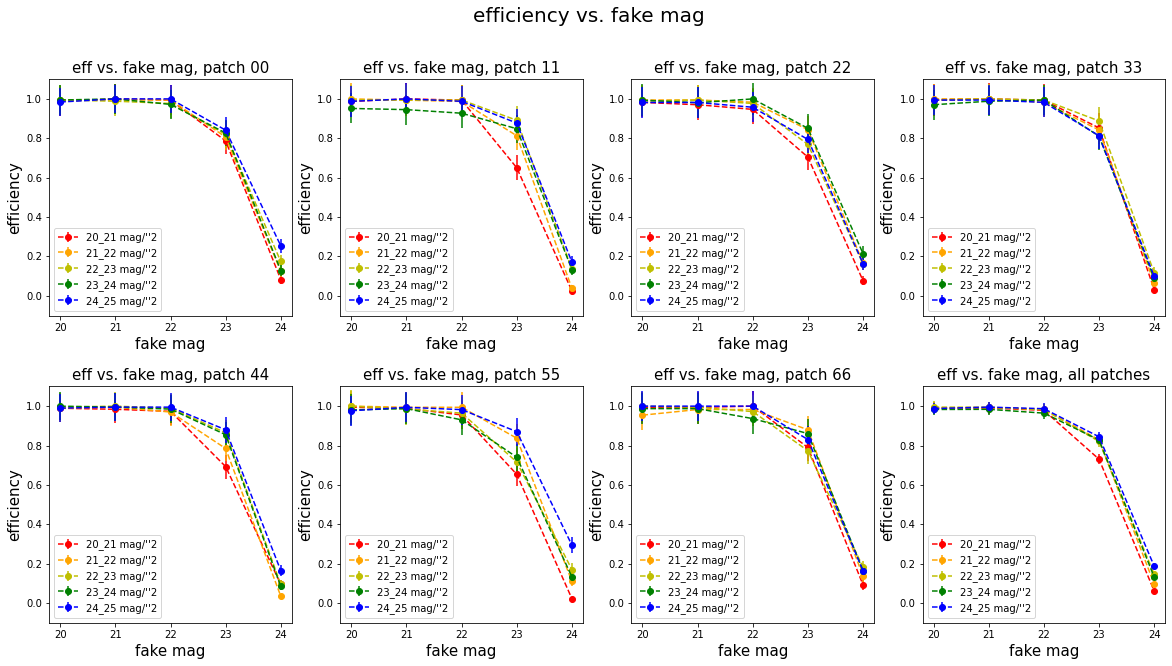

In [76]:

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
fig.subplots_adjust(hspace=0.3)
ax_list = [i for i in ax.flat]

for idx, patch in enumerate(full_patch_list):
    eff_dict = eff_dict_dict[f'{patch}']
    err_dict = err_dict_dict[f'{patch}']
    if idx == 7:
        title = 'eff vs. fake mag, all patches'
    else:
        title = f'eff vs. fake mag, patch {patch}'
    
    faf.plot_detection(ax_list[idx], eff_dict, err_dict, title)
plt.suptitle('efficiency vs. fake mag', size=20)
plt.savefig('../figures/eff.png')

In [74]:
median_dict_dict, mad_dict_dict = {}, {}
for patch in full_patch_list:
    median_dict, mad_dict = faf.get_median_mad(fake_src_dict[patch])
    median_dict_dict[patch] = median_dict
    mad_dict_dict[patch] = mad_dict

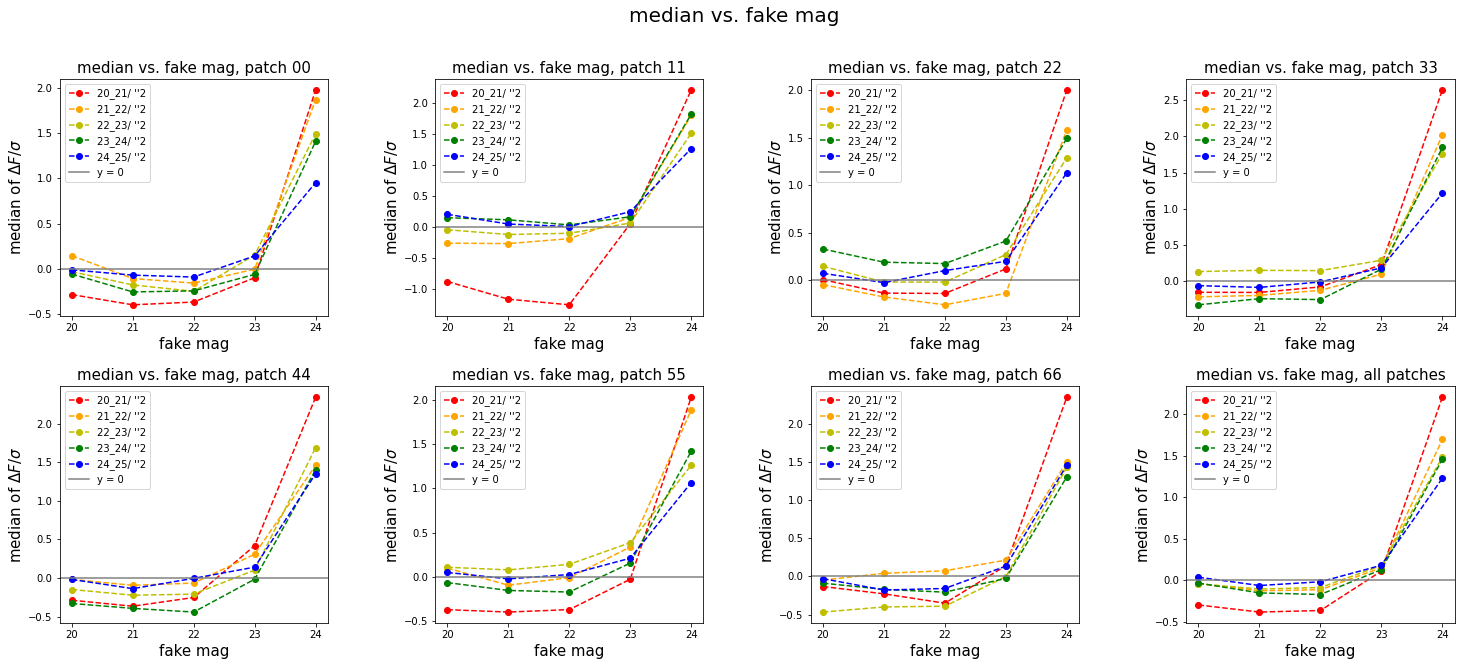

In [77]:
fig, ax = plt.subplots(2, 4, figsize=(25, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
ax_list = [i for i in ax.flat]

for idx, patch in enumerate(full_patch_list):
    median_dict = median_dict_dict[f'{patch}']
    if idx == 7:
        title = 'median vs. fake mag, all patches'
    else:
        title = f'median vs. fake mag, patch {patch}'
    
    faf.plot_median(ax_list[idx], median_dict, title)
plt.suptitle('median vs. fake mag', size=20)
plt.savefig('../figures/median.png')

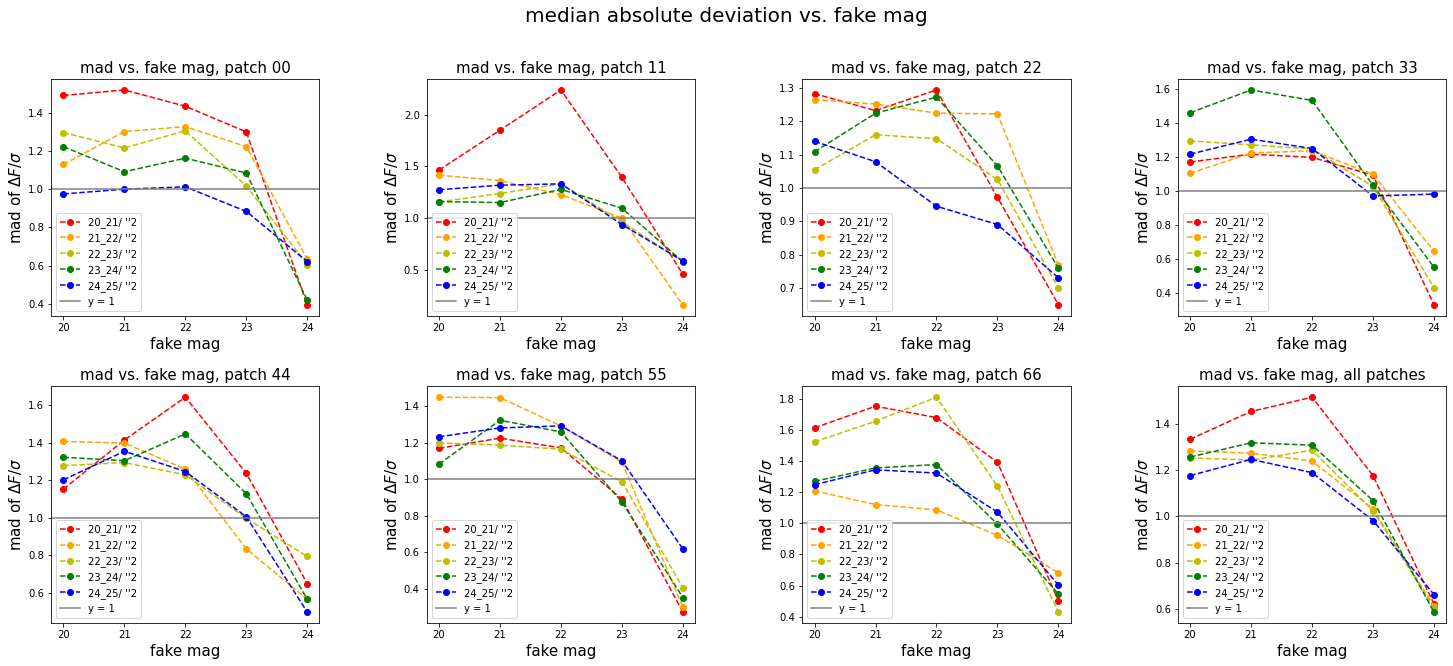

In [78]:
fig, ax = plt.subplots(2, 4, figsize=(25, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
ax_list = [i for i in ax.flat]

for idx, patch in enumerate(full_patch_list):
    mad_dict = mad_dict_dict[f'{patch}']
    if idx == 7:
        title = 'mad vs. fake mag, all patches'
    else:
        title = f'mad vs. fake mag, patch {patch}'
    
    faf.plot_mad(ax_list[idx], mad_dict, title)
plt.suptitle('median absolute deviation vs. fake mag', size=20)
plt.savefig('../figures/mad.png')

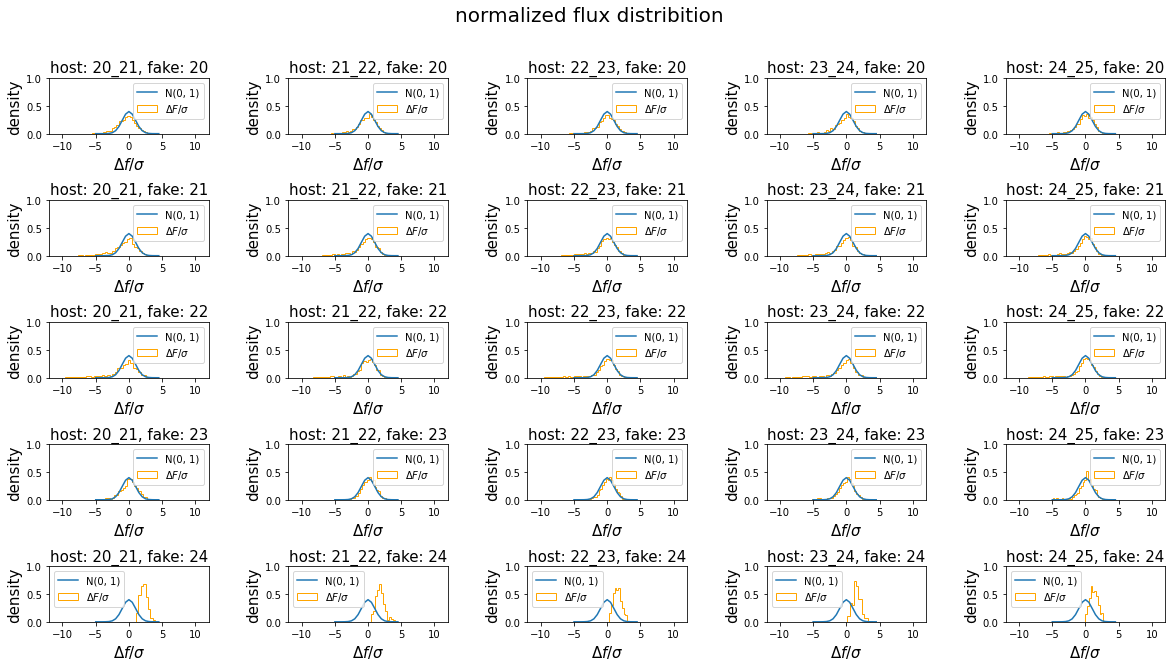

In [79]:
fig, ax = plt.subplots(5, 5, figsize=(20, 10))
fig.subplots_adjust(hspace=1.2, wspace=0.5)

for host_idx, host_mag in enumerate(host_mag_list):
    for fake_idx, fake_mag in enumerate(fake_mag_list):
        title = f'host: {host_mag}, fake: {fake_mag}'
        xlim = (-12, 12)
        bins = np.linspace(-10, 10, 200)
        df = faf.get_df(fake_src_dict['full'], host_mag, fake_mag)
        faf.plot_df(ax[fake_idx][host_idx], df, title, xlim, bins='auto', color='orange')
        
plt.suptitle("normalized flux distribition", fontsize=20)
plt.savefig('../figures/df.png')

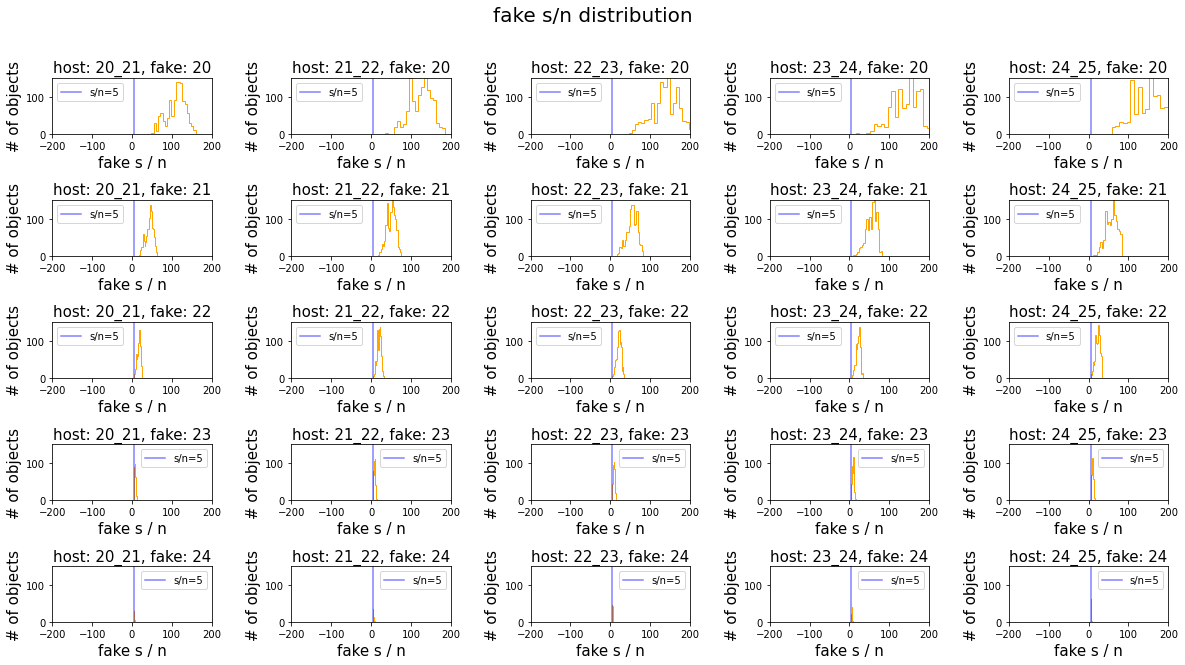

In [80]:
fig, ax = plt.subplots(5, 5, figsize=(20, 10))
fig.subplots_adjust(hspace=1.2, wspace=0.5)

for host_idx, host_mag in enumerate(host_mag_list):
    for fake_idx, fake_mag in enumerate(fake_mag_list):
        s2n = faf.get_s2n(fake_src_dict['full'], host_mag, fake_mag)
        min_x, max_x = np.min(s2n), np.max(s2n)
        max_x = max(np.abs(min_x), np.abs(max_x))
        # min_x = -max_x-0.2*max_x
        # max_x = max_x+0.2*max_x
        min_x, max_x = -200, 200
        ylim = (0, 150)
        title = f'host: {host_mag}, fake: {fake_mag}'
        faf.plot_s2n(ax[fake_idx][host_idx], s2n, title, min_x, max_x, ylim, bins='auto', color='orange')
    
plt.suptitle("fake s/n distribution", fontsize=20)
plt.savefig('../figures/s2n.png')

In [81]:
flux_db_path = (
    f'/global/cscratch1/sd/shl159/projects/dia_improvement/'
    f'data/patch_0to6/diff/perfect/al_default_3sig/forced/forced.sqlite'
)
conn = sqlite3.connect(flux_db_path)
query = 'SELECT * FROM forced'
forced_full = pd.read_sql_query(query, conn)


In [82]:
forced_full.loc[:, 'patch'] = forced_full['patch'].str.decode("utf-8")
forced_full.loc[:, 'host_mag'] = forced_full['host_mag'].str.decode("utf-8")
forced_full.loc[:, 'fake_mag'] = forced_full['fake_mag'].str.decode("utf-8")

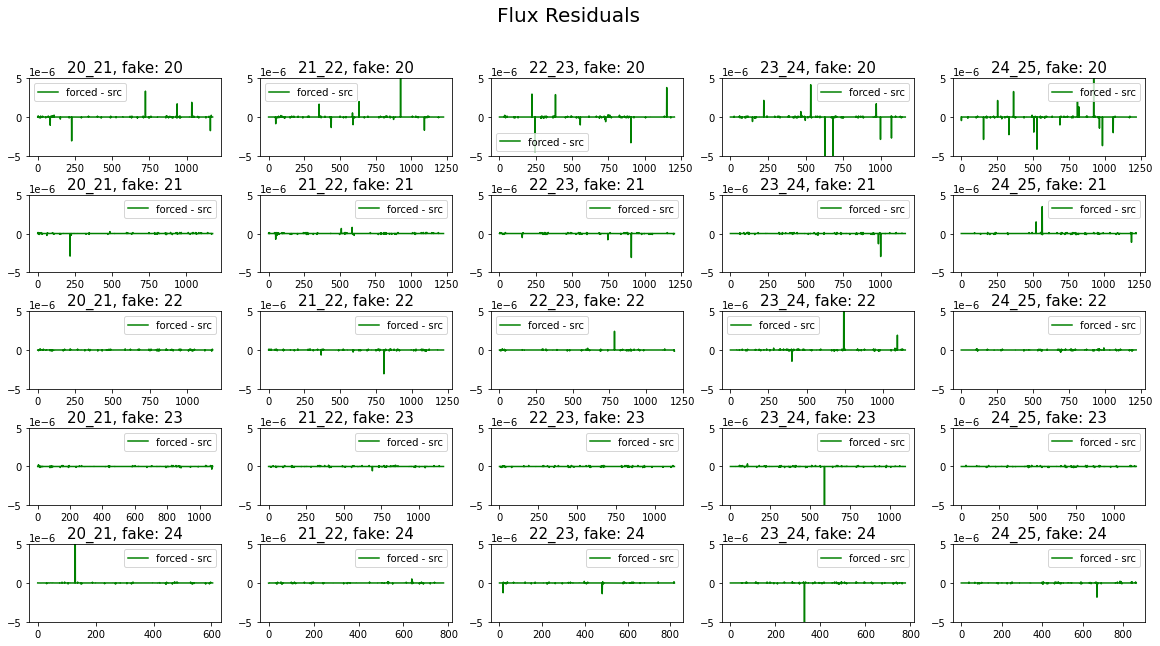

In [84]:
fig, ax = plt.subplots(5, 5, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

for host_idx, host_mag in enumerate(host_mag_list):
    for fake_idx, fake_mag in enumerate(fake_mag_list):
        src_inj, forced_inj, forced_src = faf.get_residual(forced_full, host_mag, fake_mag)
        x = np.arange(len(src_inj))
        ax[fake_idx][host_idx].plot(x, forced_src, label='forced - src', color='green')
        ax[fake_idx][host_idx].axhline(y=0.05, color='gray')
        ax[fake_idx][host_idx].axhline(y=-0.05, color='gray')
        ax[fake_idx][host_idx].set_ylim(-0.000005, 0.000005)
        ax[fake_idx][host_idx].set_title(f'{host_mag}, fake: {fake_mag}', size=15)
        ax[fake_idx][host_idx].legend()
        
plt.suptitle("Flux Residuals", fontsize=20)
plt.savefig('../figures/forced_src.png')

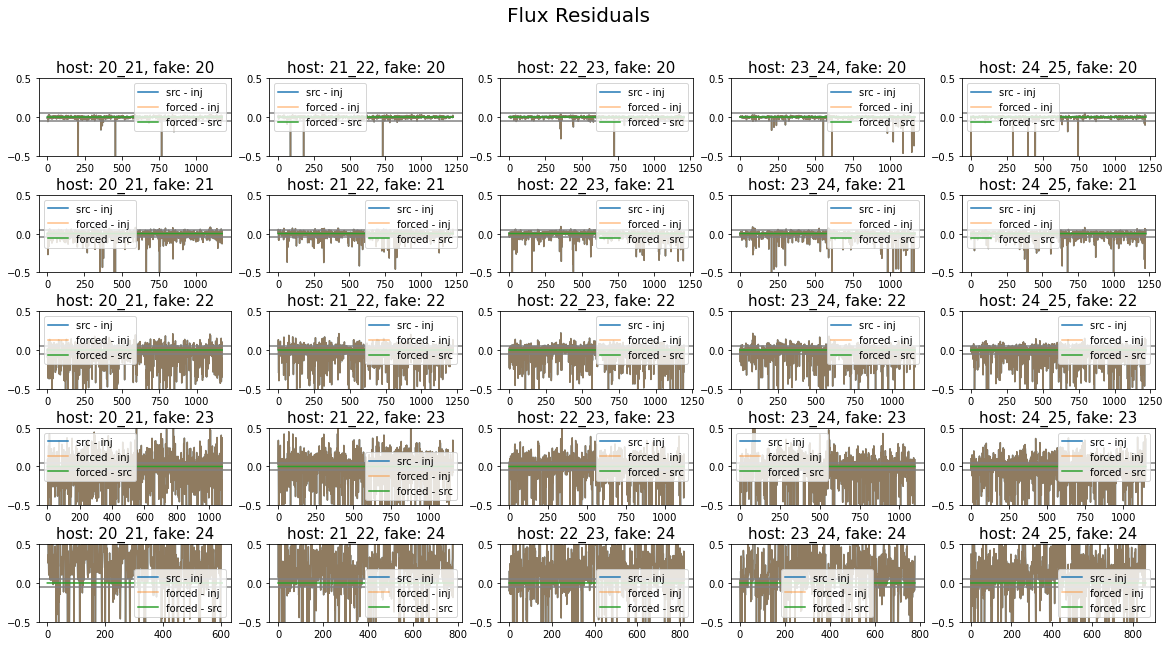

In [85]:
fig, ax = plt.subplots(5, 5, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

for host_idx, host_mag in enumerate(host_mag_list):
    for fake_idx, fake_mag in enumerate(fake_mag_list):
        src_inj, forced_inj, forced_src = faf.get_residual(forced_full, host_mag, fake_mag)
        x = np.arange(len(src_inj))
        ax[fake_idx][host_idx].plot(x, src_inj, label='src - inj')
        ax[fake_idx][host_idx].plot(x, forced_inj, alpha=0.5, label='forced - inj')
        ax[fake_idx][host_idx].plot(x, forced_src, label='forced - src')
        ax[fake_idx][host_idx].axhline(y=0.05, color='gray')
        ax[fake_idx][host_idx].axhline(y=-0.05, color='gray')
        ax[fake_idx][host_idx].set_ylim(-0.5, 0.5)
        ax[fake_idx][host_idx].set_title(f'host: {host_mag}, fake: {fake_mag}', size=15)
        ax[fake_idx][host_idx].legend()
        
plt.suptitle("Flux Residuals", fontsize=20)
plt.savefig('../figures/res.png')

In [86]:
al_eff_dict, al_err_dict, _ = faf.get_efficiency(fake_src_full, host_mag_list=host_mag_list, fake_mag_list=['20'])

In [87]:
zogy_eff_dict, zogy_err_dict, _ = faf.get_efficiency(zogy_src_df, host_mag_list=host_mag_list, fake_mag_list=['20'])

In [88]:
al_eff_list = [al_eff_dict[host_mag][0] for host_mag in host_mag_list]
al_err_list = [al_err_dict[host_mag][0] for host_mag in host_mag_list]

zogy_eff_list = [zogy_eff_dict[host_mag][0] for host_mag in host_mag_list]
zogy_err_list = [zogy_err_dict[host_mag][0] for host_mag in host_mag_list]

/tmp/ipykernel_60004/970868984.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(host_mag_list)


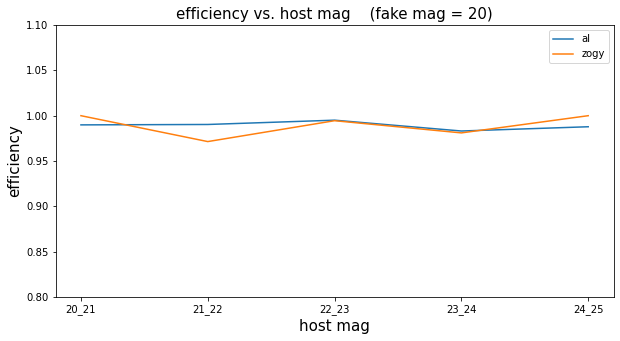

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.errorbar(np.arange(len(host_mag_list)), al_eff_list, yerr=al_err_list, label='al')
# ax.errorbar(np.arange(len(host_mag_list)), zogy_eff_list, yerr=zogy_err_list, label='zogy')

ax.plot(np.arange(len(host_mag_list)), al_eff_list, label='al')
ax.plot(np.arange(len(host_mag_list)), zogy_eff_list, label='zogy')

ax.set_xticklabels(host_mag_list)
ax.set_ylim(0.8, 1.1)

ax.set_xticks(np.arange(len(host_mag_list)))
ax.set_xlabel('host mag', size=15)
ax.set_ylabel('efficiency', size=15)
ax.legend()
ax.set_title('efficiency vs. host mag    (fake mag = 20)', size=15)
plt.savefig('../figures/zogy_eff.png')

In [90]:
def slice_df(df, equal=None, big=None, small=None):
    cond_ls = []
    if equal:
        for key, item in equal.items():
            cond_ls.append(df.loc[:, key]==item)
    if big:
        for key, item in big.items():
            cond_ls.append(df.loc[:, key]>item)
    if small:
        for key, item in small.items():
            cond_ls.append(df.loc[:, key]<item)
    if not cond_ls:
        return df.copy().reset_index(drop=True)
    else:
        index = np.logical_and.reduce(cond_ls)
        sliced_df = df.loc[index].copy().reset_index(drop=True)
        return sliced_df

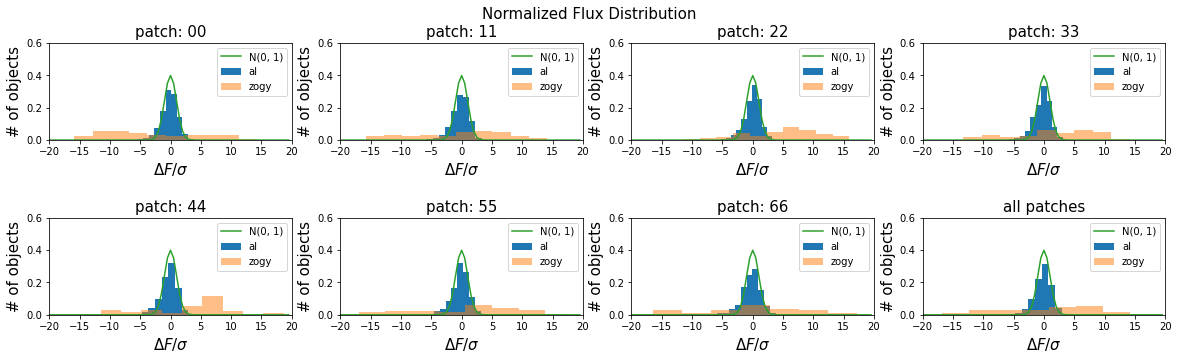

In [92]:
norm_x = np.arange(-20, 20, 0.5)
norm_y = norm.pdf(norm_x)

fig, ax = plt.subplots(2, 4, figsize=(20, 5))
fig.subplots_adjust(hspace=0.8)
ax_list = [i for i in ax.flat]

for patch_id, patch in enumerate(full_patch_list):
    if patch_id < 7:
        al_src = slice_df(fake_src_full, equal={'patch': patch, 'fake_mag': '20'})
        zogy_src = slice_df(zogy_src_full, equal={'patch': patch, 'fake_mag': '20'})
    else:
        al_src = slice_df(fake_src_full, equal={'fake_mag': '20'})
        zogy_src = slice_df(zogy_src_full, equal={'fake_mag': '20'})
        
    al_df = faf.cal_df(al_src, threshold=5)
    zogy_df = faf.cal_df(zogy_src, threshold=5)
    ax_list[patch_id].hist(al_df, density=True, label='al')
    ax_list[patch_id].hist(zogy_df, alpha=0.5, density=True, label='zogy')
    ax_list[patch_id].plot(norm_x, norm_y, label='N(0, 1)')
    ax_list[patch_id].set_xlabel(r'$\Delta F / \sigma$', size=15)
    ax_list[patch_id].set_ylabel('# of objects', size=15)
    if patch_id < 7:
        ax_list[patch_id].set_title(f'patch: {patch}', size=15)
    else:
        ax_list[patch_id].set_title(f'all patches', size=15)
    ax_list[patch_id].set_xlim(-20, 20)
    ax_list[patch_id].set_ylim(0, 0.6)
    ax_list[patch_id].legend()
plt.suptitle("Normalized Flux Distribution", fontsize=15)
plt.savefig('../figures/zogy_al.png')